In [2]:
import src.data.data_load as data_load
import src.data.processing as processing
import src.data.imputing as imputing
import src.data.feature_engin as feature_engin

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# TASK 1A: EXPLORATORY DATA ANALYSIS

In [5]:
df = data_load.load_mood_dataset("./raw_data/dataset_mood_smartphone.csv")
# 快速了解缺失情况
print(df.isnull().mean().sort_values(ascending=False))
print("there are {} rows in the dataset".format(df.shape[0]))
print("there are {} columns in the dataset".format(df.shape[1]))

variable
appCat.weather          0.999290
appCat.game             0.997735
appCat.unknown          0.997384
appCat.finance          0.997384
sms                     0.994991
appCat.utilities        0.993071
appCat.travel           0.992071
call                    0.985404
circumplex.valence      0.984749
circumplex.arousal      0.984448
mood                    0.984320
appCat.office           0.984281
appCat.other            0.978686
appCat.social           0.946660
activity                0.936017
appCat.entertainment    0.924427
appCat.communication    0.793060
appCat.builtin          0.745663
screen                  0.730925
time                    0.000000
id                      0.000000
dtype: float64
there are 358926 rows in the dataset
there are 21 columns in the dataset


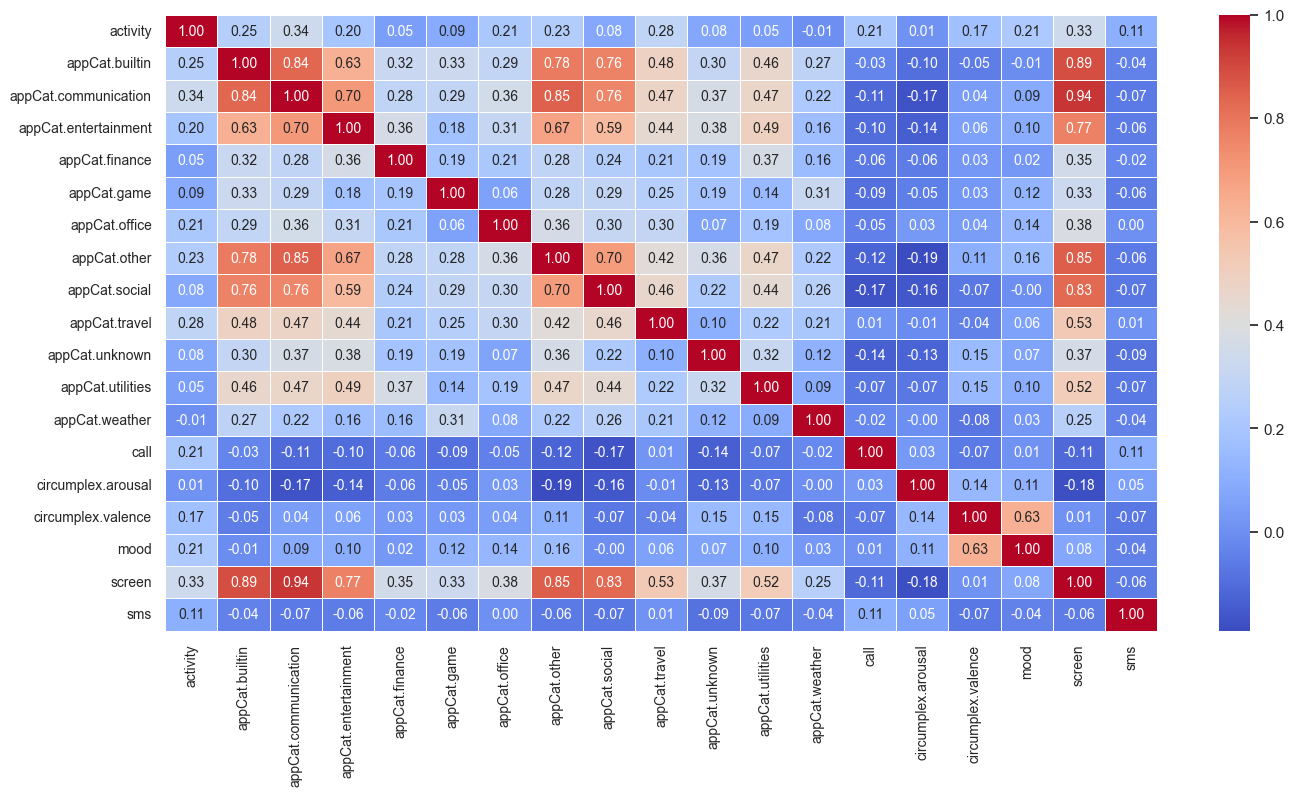

In [19]:
# Step 1: 计算协方差矩阵（自动跳过 NaN）
filepath = "./raw_data/dataset_mood_smartphone_wide.csv"
df_raw = pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)
df_raw['time'] = pd.to_datetime(df_raw['time'])
df_daily = processing.aggregate_by_day(df_raw)

# 假设你的 DataFrame 叫 df_raw
df_daily['date'] = pd.to_datetime(df_daily['date'])  # 确保 date 列是 datetime 类型

numeric_df = df_daily.drop(columns=['id', 'date'])
corr_matrix = numeric_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


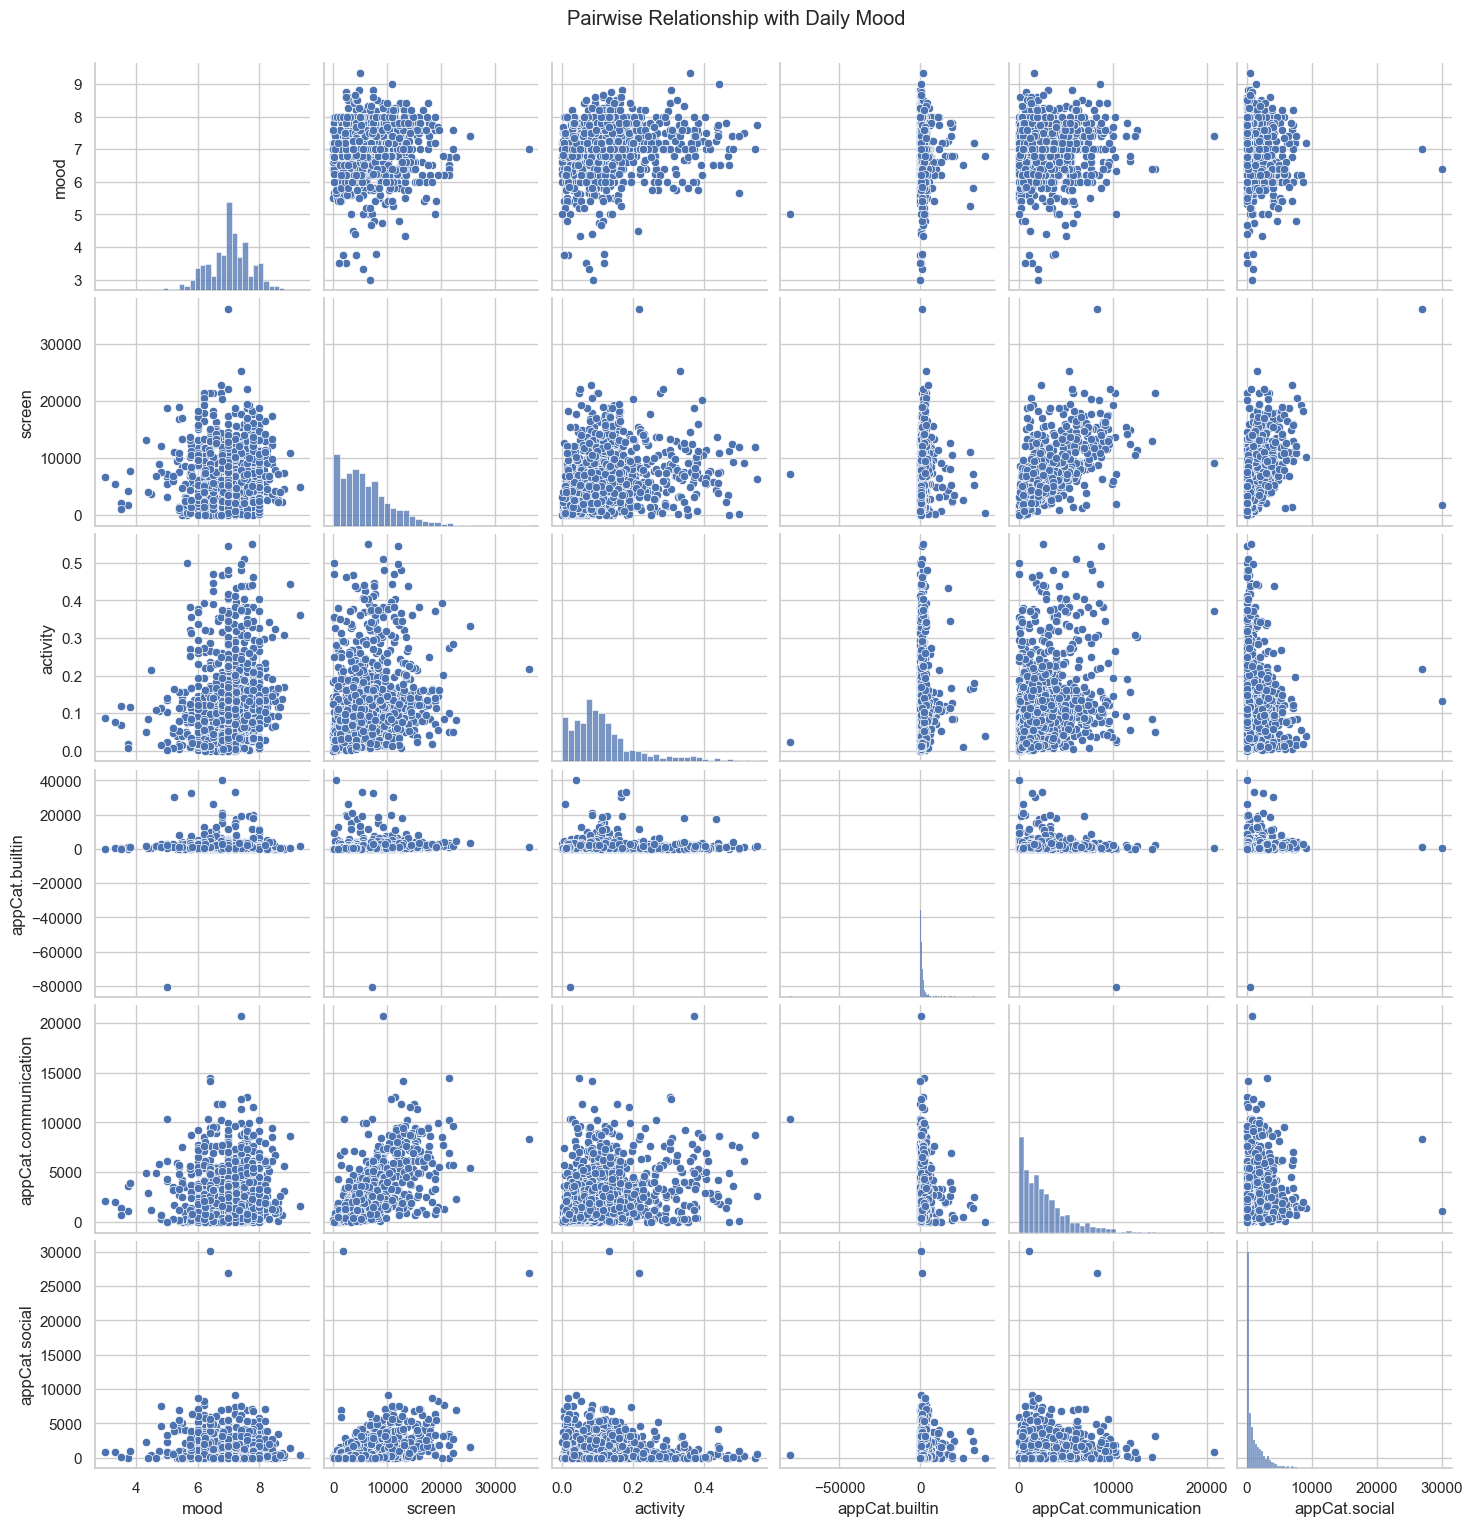

In [20]:
# 选择几个核心行为变量做pairplot
selected = ['mood', 'screen', 'activity', 'appCat.builtin', 'appCat.communication', 'appCat.social']
sns.pairplot(df_daily[selected].dropna())
plt.suptitle("Pairwise Relationship with Daily Mood", y=1.02)
plt.show()

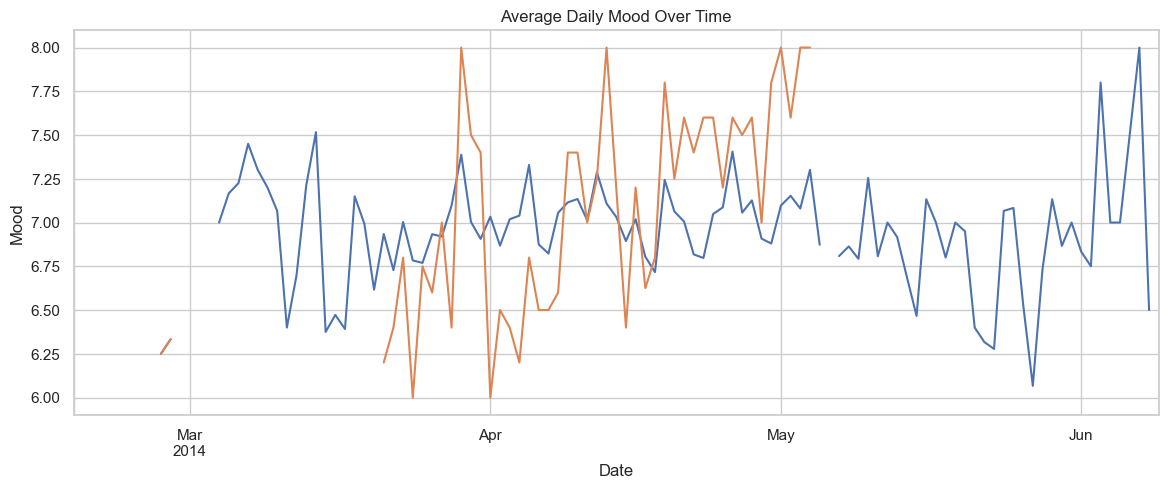

In [15]:
# 每天整体 mood 均值（全体人平均）

mood_trend = df_daily.groupby('date')['mood'].mean()


plt.figure(figsize=(14, 5))
mood_trend.plot()
df_daily[df_daily['id'] == 'AS14.01'].set_index('date')['mood'].plot()
plt.title("Average Daily Mood Over Time")
plt.ylabel("Mood")
plt.xlabel("Date")
plt.grid(True)
plt.show()

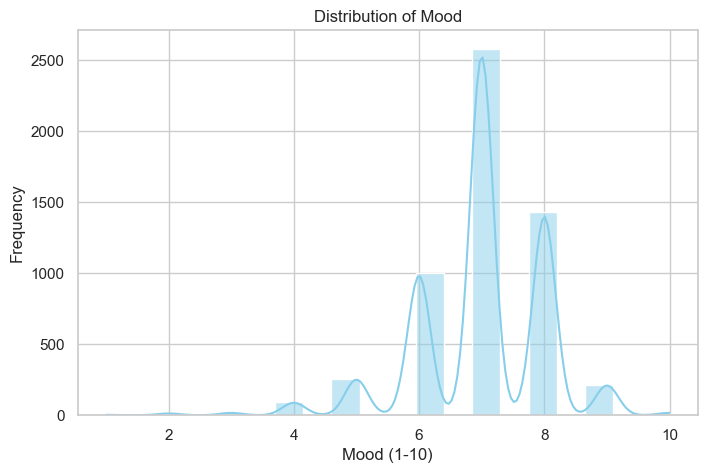

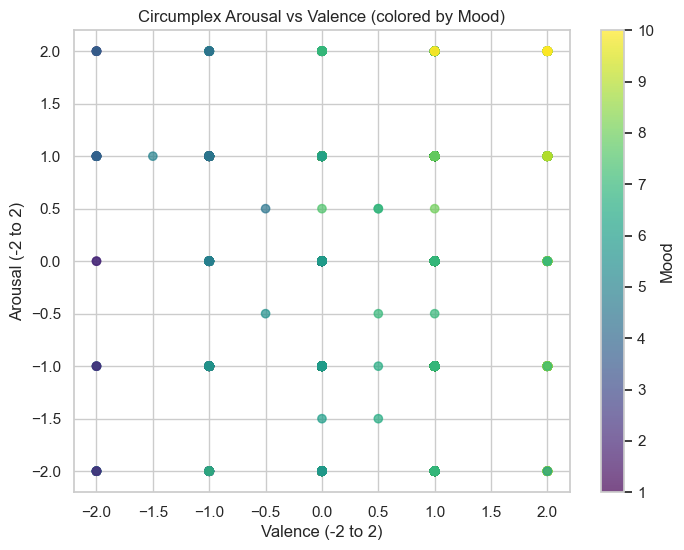

C:\Users\alex\AppData\Local\Temp\ipykernel_33520\3031439780.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Call (1)', 'SMS (1)'], y=[call_count, sms_count], palette="pastel")


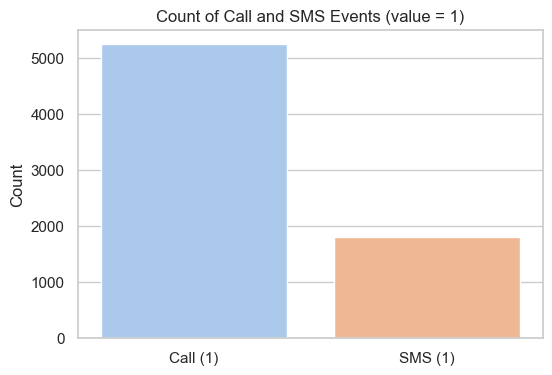

In [8]:
# 载入数据
df = data_load.load_mood_dataset("./raw_data/dataset_mood_smartphone.csv")

# 设置绘图风格
sns.set_theme(style="whitegrid")

# 1️⃣ 直方图：mood 分布
plt.figure(figsize=(8, 5))
sns.histplot(df['mood'].dropna(), bins=20, kde=True, color='skyblue')
plt.title("Distribution of Mood")
plt.xlabel("Mood (1-10)")
plt.ylabel("Frequency")
plt.show()

# 2️⃣ 散点图：circumplex.arousal vs circumplex.valence，颜色映射 mood
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df['circumplex.valence'],
    df['circumplex.arousal'],
    c=df['mood'],
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label="Mood")
plt.title("Circumplex Arousal vs Valence (colored by Mood)")
plt.xlabel("Valence (-2 to 2)")
plt.ylabel("Arousal (-2 to 2)")
plt.grid(True)
plt.show()

# 3️⃣ 条形图：call 和 sms 中值为 1 的数量
call_count = df['call'].value_counts().get(1.0, 0)
sms_count = df['sms'].value_counts().get(1.0, 0)

plt.figure(figsize=(6, 4))
sns.barplot(x=['Call (1)', 'SMS (1)'], y=[call_count, sms_count], palette="pastel")
plt.title("Count of Call and SMS Events (value = 1)")
plt.ylabel("Count")
plt.show()


# TASK 1B: DATA CLEANING

## 1B.1 remove outliers

In [14]:
# here is manually defined features to use, from the EDA results above
features_to_use = [
    'screen',
    'activity',
    'appCat.builtin',
    'appCat.communication',
    'appCat.social',
]

optional_features = [
    'call',
    'sms',
    'circumplex.arousal',
    'circumplex.valence',
    'appCat.entertainment',

    'appCat.other',
    'appCat.office',
]

# 加载数据
df = data_load.load_mood_dataset("./raw_data/dataset_mood_smartphone.csv")

# 删除缺失率高于 99.5% 的列
cleaned_df = processing.drop_high_nan_columns(df, threshold=0.99)

# 删除 optional_features 中的列
cleaned_df.drop(columns=optional_features, inplace=True, errors='ignore')
print("cleaned_df data:", cleaned_df.isnull().mean().sort_values(ascending=False))        # 快速了解缺失情况

# 并按天聚合的数据
df_daily = processing.aggregate_by_day(cleaned_df)
df_daily.to_csv("./raw_data/cleaned_data_daily_summary.csv", index=False)
print("df_daily data:", df_daily.isnull().mean().sort_values(ascending=False))        # 快速了解缺失情况


删除的列数: 7
被删除的列: ['appCat.finance', 'appCat.game', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'sms']
cleaned_df data: variable
mood                    0.984320
appCat.social           0.946660
activity                0.936017
appCat.communication    0.793060
appCat.builtin          0.745663
screen                  0.730925
id                      0.000000
time                    0.000000
dtype: float64
df_daily data: variable
activity                0.397871
mood                    0.357324
date                    0.000000
id                      0.000000
appCat.builtin          0.000000
appCat.communication    0.000000
appCat.social           0.000000
screen                  0.000000
dtype: float64


In [15]:
filepath = "./raw_data/cleaned_data_daily_summary.csv"
df_daily = pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)

# 聚合后，二次清洗mood为空的数据
print(f"原始按天聚合数据共 {len(df_daily)} 条")
df_daily = df_daily[df_daily['mood'].notna()].reset_index(drop=True)
print(f"保留含有 mood 值的数据共 {len(df_daily)} 条")
df_daily.to_csv("./raw_data/cleaned_data_daily_summary_mood.csv", index=False)

# 二次清理后，还剩下一些缺失情况
print("df_daily data:", df_daily.isnull().mean().sort_values(ascending=False))        # 快速了解缺失情况

原始按天聚合数据共 1973 条
保留含有 mood 值的数据共 1268 条
df_daily data: activity                0.09306
id                      0.00000
date                    0.00000
appCat.builtin          0.00000
appCat.communication    0.00000
appCat.social           0.00000
mood                    0.00000
screen                  0.00000
dtype: float64


## 1B.2 Imputing Missing Values

In [16]:
filepath = "./raw_data/cleaned_data_daily_summary_mood.csv"
df_daily = pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)

# 进行缺失值填充
df_method1 = imputing.imputing_with_zero(df_daily)
df_method2 = imputing.imputing_with_mean(df_daily)
df_method3 = imputing.imputing_with_removal_NaN(df_daily)
df_method2.to_csv("./raw_data/cleaned_data_daily_summary_mood_imputed.csv", index=False)

print("Method 1 shape:", df_method1.shape)
print("Method 2 shape:", df_method2.shape)
print("Method 3 shape:", df_method3.shape)

Method 1 shape: (1268, 8)
Method 2 shape: (1268, 8)
Method 3 shape: (1183, 8)


d:\code-repo\作业\dmt_assignments\1\src\data\imputing.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_method2[feature_cols] = df_method2.groupby('id')[feature_cols].transform(lambda x: x.fillna(x.mean()))
d:\code-repo\作业\dmt_assignments\1\src\data\imputing.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_method2[feature_cols] = df_method2.groupby('id')[feature_cols].transform(lambda x: x.fillna(x.mean()))
d:\code-repo\作业\dmt_assignments\1\src\data\imputing.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is de

# TASK 1C: FEATURE ENGINEERING

In [17]:
# 加载数据
filepath = "./raw_data/cleaned_data_daily_summary_mood_imputed.csv"
df = pd.read_csv(filepath) if filepath.endswith('.csv') else pd.read_excel(filepath)
df['date'] = pd.to_datetime(df['date'])  # 确保是 datetime 类型
df_features = feature_engin.create_sliding_window_dataset(df, window_size=5)

print(df_features.head())
print("构造后的样本总数:", len(df_features))

df_features.to_csv("./raw_data/cleaned_data_daily_summary_mood_imputed_sliding_window.csv", index=False)


        id       date  mood_target  mood_hist_mean  activity_hist_mean  \
0  AS14.01 2014-03-26          6.6            6.43            0.138201   
1  AS14.01 2014-03-27          7.0            6.51            0.131653   
2  AS14.01 2014-03-28          6.4            6.63            0.116179   
3  AS14.01 2014-03-29          8.0            6.55            0.106770   
4  AS14.01 2014-03-30          7.5            6.95            0.104619   

   appCat.builtin_hist_mean  appCat.communication_hist_mean  \
0                 1411.3234                       7205.7014   
1                 1016.9792                       7747.2740   
2                 1116.5588                       8141.9928   
3                 2871.8286                       7267.8956   
4                 3088.9634                       5957.9082   

   appCat.social_hist_mean  screen_hist_mean  
0                2198.4136        13483.5212  
1                2215.1254        13172.5000  
2                2314.2752        1